In [1]:
import torch
import pyro
from stimulus import Stimulus

pyro.set_rng_seed(101)

In [4]:
loc = 0.   # mean zero
scale = 1. # unit variance
normal = torch.distributions.Normal(loc, scale) # create a normal distribution object
x = normal.rsample() # draw a sample from N(0,1)
print("sample", x)
print("log prob", normal.log_prob(x)) # score the sample from N(0,1)

sample tensor(-0.3204)
log prob tensor(-0.9703)


In [13]:
def weather():
    cloudy = torch.distributions.Bernoulli(0.3).sample()
    cloudy = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 55.0, 'sunny': 75.0}[cloudy]
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[cloudy]
    temp = torch.distributions.Normal(mean_temp, scale_temp).rsample()
    return cloudy, temp.item()

for _ in range(3):
    print(weather())

('sunny', 65.28289794921875)
('sunny', 75.08171844482422)
('cloudy', 42.013938903808594)


In [14]:
x = pyro.sample("my_sample", pyro.distributions.Normal(loc, scale))
print(x)

tensor(-0.6378)


In [15]:
def weather():
    cloudy = pyro.sample('cloudy', pyro.distributions.Bernoulli(0.3))
    cloudy = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 55.0, 'sunny': 75.0}[cloudy]
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[cloudy]
    temp = pyro.sample('temp', pyro.distributions.Normal(mean_temp, scale_temp))
    return cloudy, temp.item()

for _ in range(3):
    print(weather())

    

('cloudy', 63.97516632080078)
('cloudy', 65.64017486572266)
('sunny', 60.599517822265625)


In [16]:
def ice_cream_sales():
    cloudy, temp = weather()
    expected_sales = 200. if cloudy == 'sunny' and temp > 80.0 else 50.
    ice_cream = pyro.sample('ice_cream', pyro.distributions.Normal(expected_sales, 10.0))
    return ice_cream

In [20]:
def geometric(p, t=None):
    if t is None:
        t = 0
    x = pyro.sample("x_{}".format(t), pyro.distributions.Bernoulli(p))
    if x.item() == 1:
        return 0
    else:
        return 1 + geometric(p, t + 1)

print(geometric(0.5))

2


In [24]:
def normal_product(loc, scale):
    z1 = pyro.sample("z1", pyro.distributions.Normal(loc, scale))
    z2 = pyro.sample("z2", pyro.distributions.Normal(loc, scale))
    print("z1",z1,"z2",z2)
    y = z1 * z2
    return y

def make_normal_normal():
    mu_latent = pyro.sample("mu_latent", pyro.distributions.Normal(0, 1))
    print("ML",mu_latent)
    fn = lambda scale: normal_product(mu_latent, scale)
    return fn

print(make_normal_normal()(1.))

ML tensor(-0.1057)
z1 tensor(-0.3197) z2 tensor(1.2876)
tensor(-0.4116)


# Part 2

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

pyro.set_rng_seed(101)

In [42]:
# def sample_and_show(fn, num_its=1000)

In [48]:
def scale(guess):
    weight = pyro.sample("weight",dist.Normal(guess,1.0))
    conditioned_scale = pyro.condition(scale, data={"measurement": 9.5})
    return pyro.sample("measurement",dist.Normal(weight,.75))

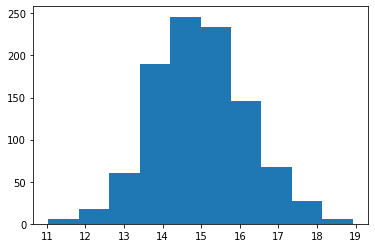

In [50]:
scales = []
for i in range(1000):
    guess = 15
    scales.append(scale(guess))

plt.hist(scales)
plt.show()

In [28]:
conditioned_scale = pyro.condition(scale, data={"measurement": 9.5})

In [29]:
def deferred_conditioned_scale(measurement, guess):
    return pyro.condition(scale, data={"measurement": measurement})(guess)

In [33]:
deferred_conditioned_scale(9.5,9)

9.5

In [44]:
def scale_obs(guess):  # equivalent to conditioned_scale above
    weight = pyro.sample("weight", dist.Normal(guess, 1.))
     # here we condition on measurement == 9.5
    measurement = pyro.sample("measurement", dist.Normal(weight, 1.), obs=9.5)
    return weight

In [45]:
scale_obs(guess)

tensor(8.7441)

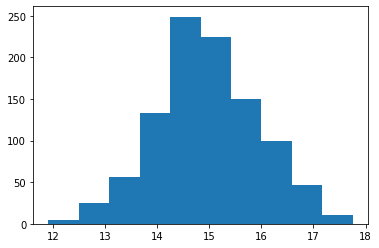

In [47]:
scales_obs = []
for i in range(1000):
    guess = 15
    scales_obs.append(scale_obs(guess))

plt.hist(scales_obs)
plt.show()